In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import logging
logging.basicConfig()

from pathlib import Path
from pprint import pprint
import itertools

from tqdm import tqdm, trange

import numpy as np
import matplotlib.pyplot as plt
import skimage
import cv2 as cv

import quinoa as q

In [2]:
NOTEBOOK_NAME = "segment_seeds"

HERE = Path.cwd().absolute()
DATA = HERE.parent / "data"
OUT = HERE / "out" / Path(NOTEBOOK_NAME).stem
print(HERE)
print(DATA)
print(OUT)

D:\projects\quinoa\dev
D:\projects\quinoa\data
D:\projects\quinoa\dev\out\segment_seeds


In [3]:
# img_bgr = q.read_image(DATA / "IMG_0477.JPG")
img_bgr = q.read_image(DATA / "IMG_0497.JPG")
# img_bgr = q.read_image(DATA / "IMG_9465.JPG")

print(img_bgr.shape)

DEBUG:quinoa.io:Loaded image from D:\projects\quinoa\data\IMG_0497.JPG


(2432, 3648, 3)


In [4]:
corners = q.find_card_corners(image_bgr=img_bgr)
new_corners = q.determine_new_corners(corners)
crop_slice = q.corners_to_slice(new_corners)
rectifier = q.get_rectifier(corners, new_corners)

img_bgr_cropped = rectifier(img_bgr)[crop_slice]
img_lab_cropped = q.convert_colorspace(img_bgr_cropped, cv.COLOR_BGR2LAB)
img_l_cropped = img_lab_cropped[..., 0]
img_b_cropped = img_lab_cropped[..., 2]

In [5]:
# q.show_image(
#     skimage.util.montage(np.moveaxis(img_lab_cropped, [-1], [0]), fill = 0)
# )

In [6]:
l_thresh, img_l_thresholded = cv.threshold(
    img_l_cropped, 225, maxval=255, type=cv.THRESH_BINARY
)

# q.show_image(img_l_thresholded)

In [7]:
img_l_closed = cv.morphologyEx(
    img_l_thresholded,
    cv.MORPH_CLOSE,
    kernel=cv.getStructuringElement(cv.MORPH_ELLIPSE, (3, 3)),
)

# q.show_image(img_l_closed)

In [8]:
num_labels, img_labels, stats, centroids = cv.connectedComponentsWithStats(
    img_l_closed, connectivity=8
)
img_numbers = np.zeros_like(img_l_closed)

for label in range(1, num_labels):
    if stats[label, cv.CC_STAT_AREA] < 30:
        continue

    img_numbers[label == img_labels] = 255

# q.show_image(img_numbers)

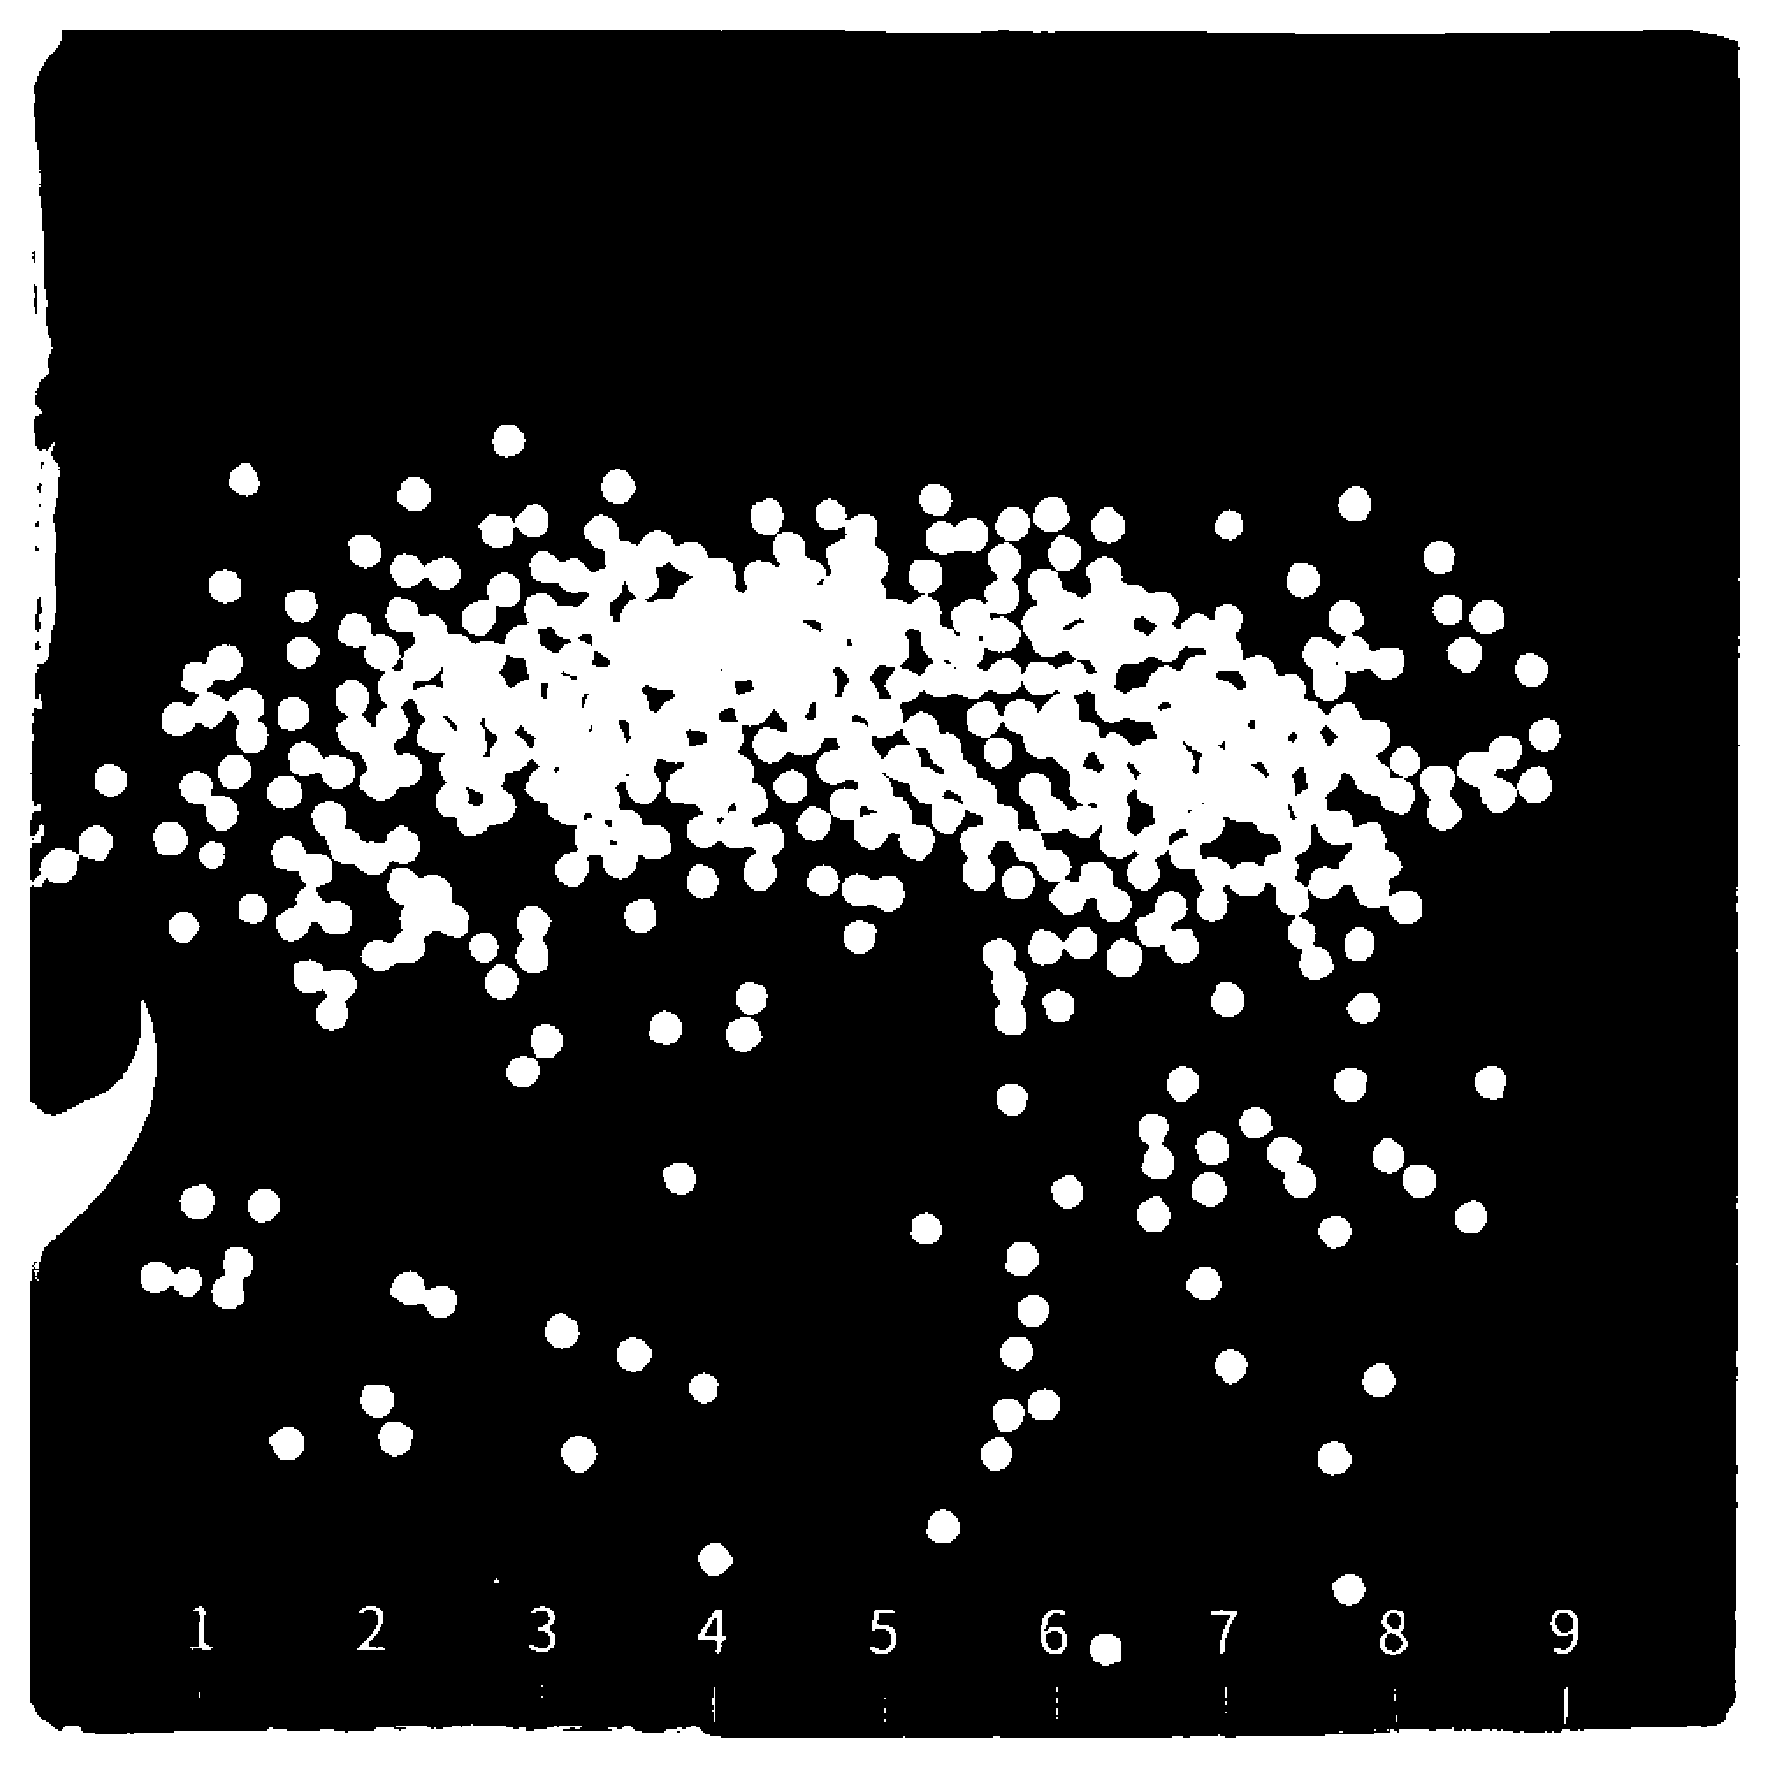

In [21]:
thresh, img_thresholded = cv.threshold(
    img_b_cropped, 0, maxval=255, type=cv.THRESH_OTSU
)

q.show_image(img_thresholded)

In [11]:
num_labels, img_labels, stats, centroids = cv.connectedComponentsWithStats(
    img_thresholded, connectivity=8
)

DEBUG:quinoa.io:Wrote image (size (972, 973, 3)) to D:\projects\quinoa\dev\out\segment_seeds\labels.png


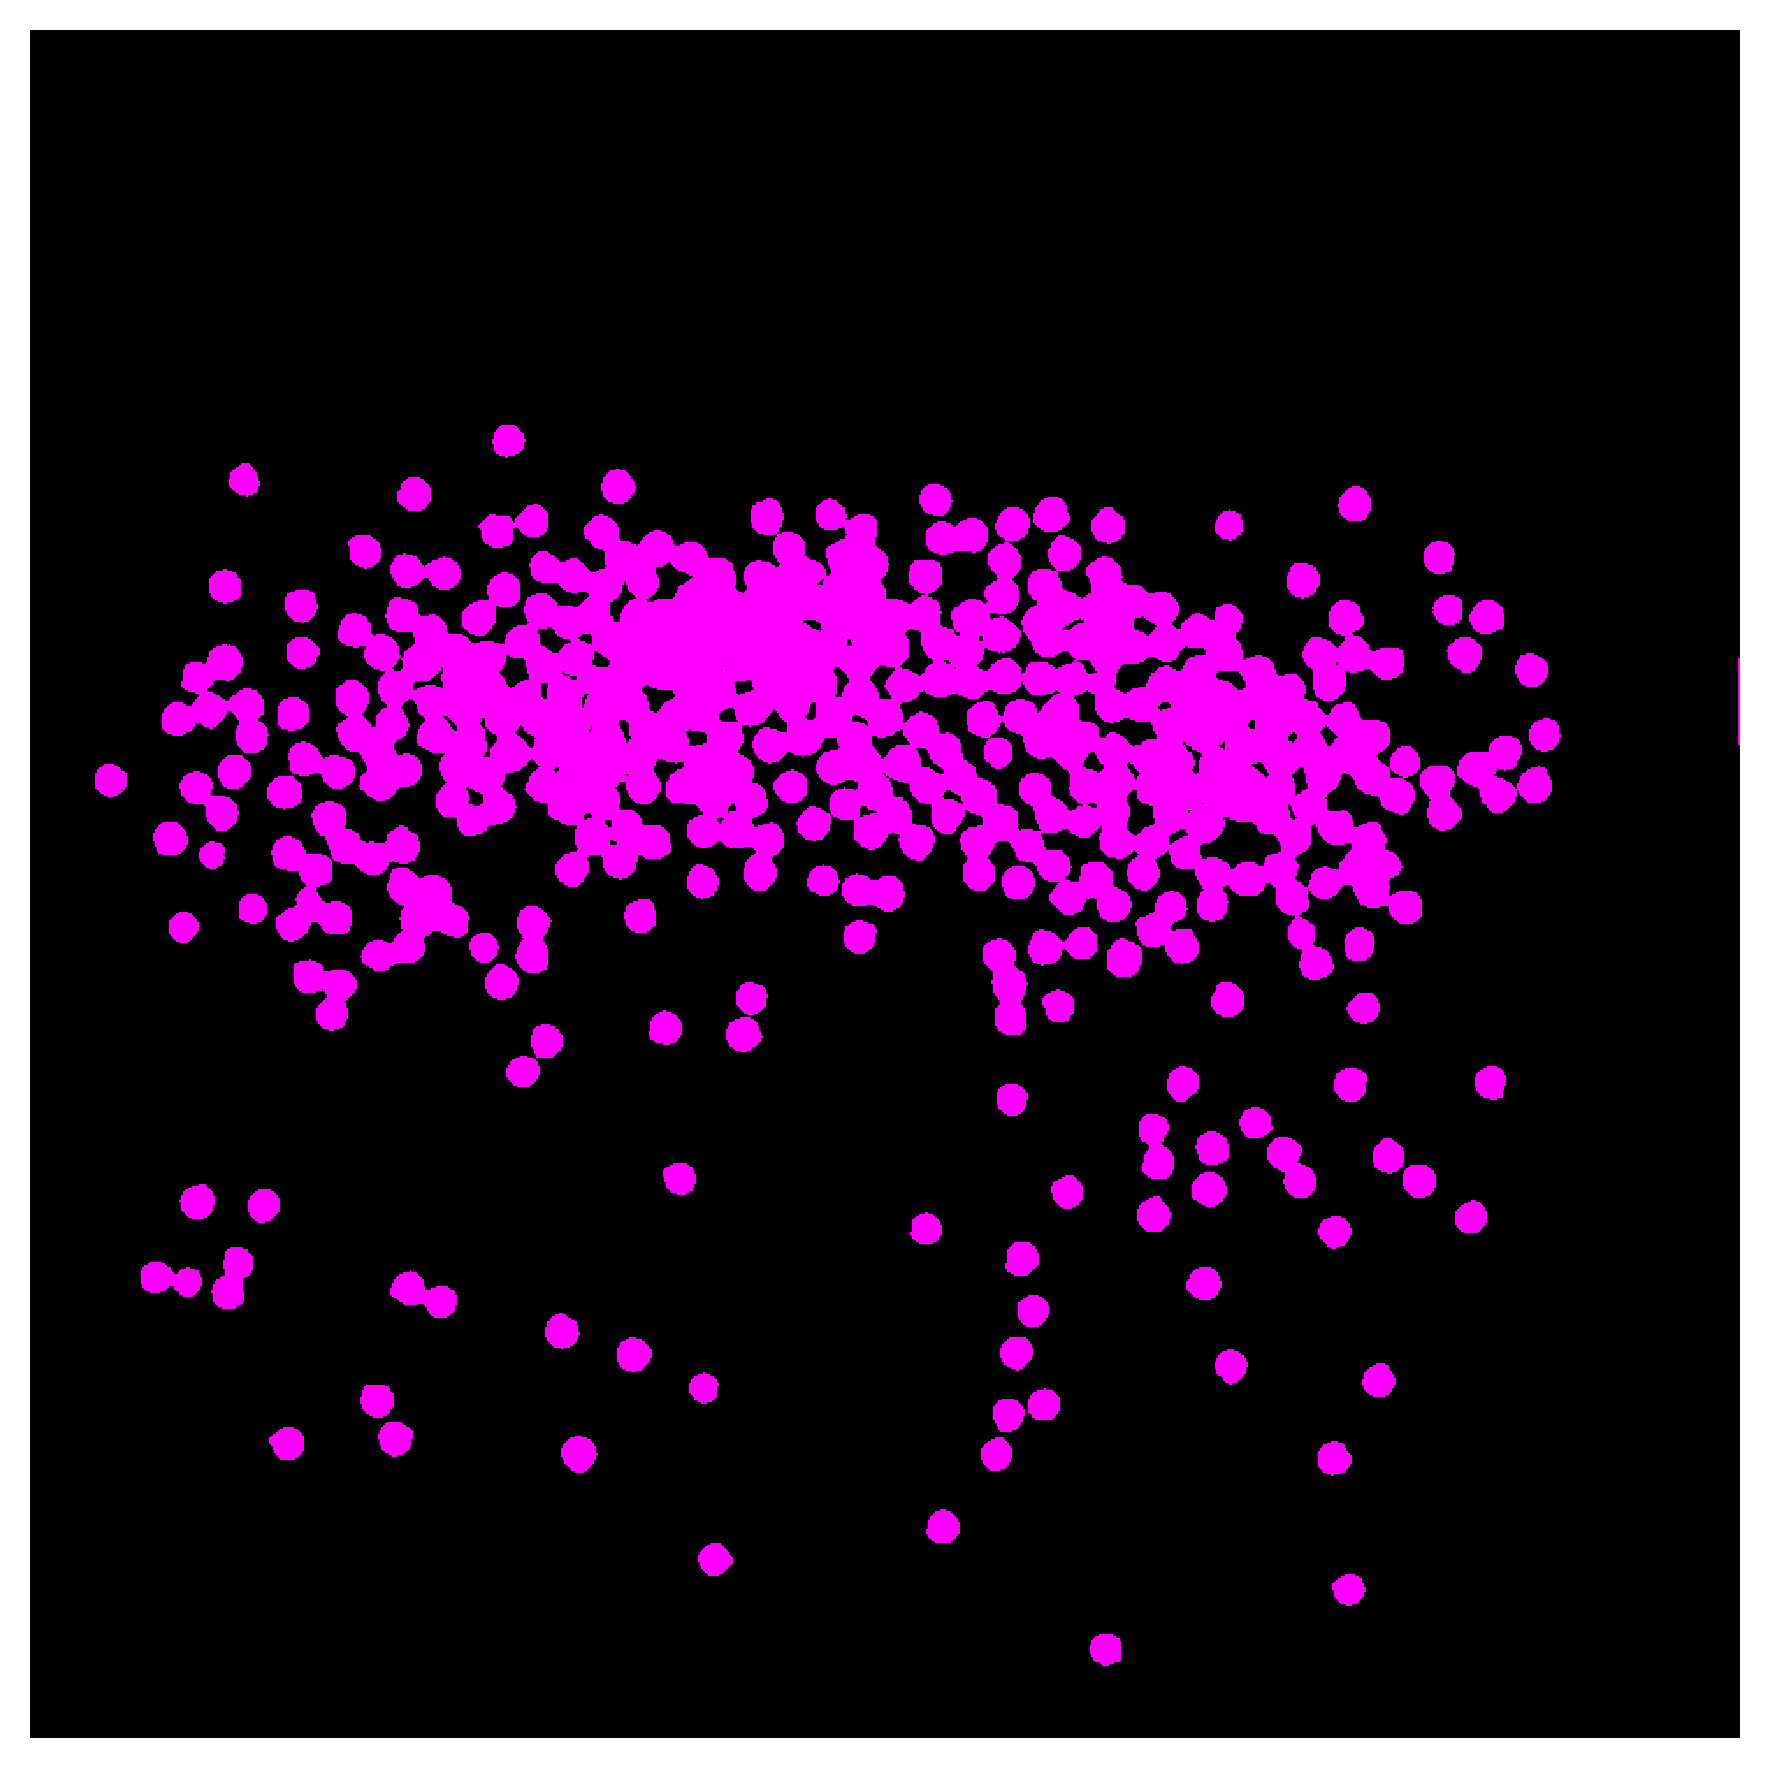

In [24]:
show_labels = np.zeros_like(img_bgr_cropped)

# use this to cut everything near the edges of the image
boundary_width = 3
edges = np.zeros_like(img_b_cropped)
edges[0:boundary_width, :] = 1
edges[:, 0:boundary_width] = 1
edges[-boundary_width:-1, :] = 1
edges[:, -boundary_width:-1] = 1

# colors = q.BGR_COLORS
colors = [q.MAGENTA]
for label, color in zip(range(1, num_labels), itertools.cycle(colors)):
    area = stats[label, cv.CC_STAT_AREA]
    if area < 40:
        continue

    in_label = np.where(label == img_labels, 1, 0).astype(np.uint8)

    if np.any(cv.bitwise_and(edges, in_label)):
        continue

    cv.bitwise_and(in_label, img_numbers)
    if np.count_nonzero(cv.bitwise_and(in_label, img_numbers)) > 0.5 * area:
        continue

    show_labels[label == img_labels] = color

q.write_image(show_labels, OUT / 'labels.png')
q.show_image(show_labels)

DEBUG:quinoa.io:Wrote image (size (972, 973, 3)) to D:\projects\quinoa\dev\out\segment_seeds\overlay.png


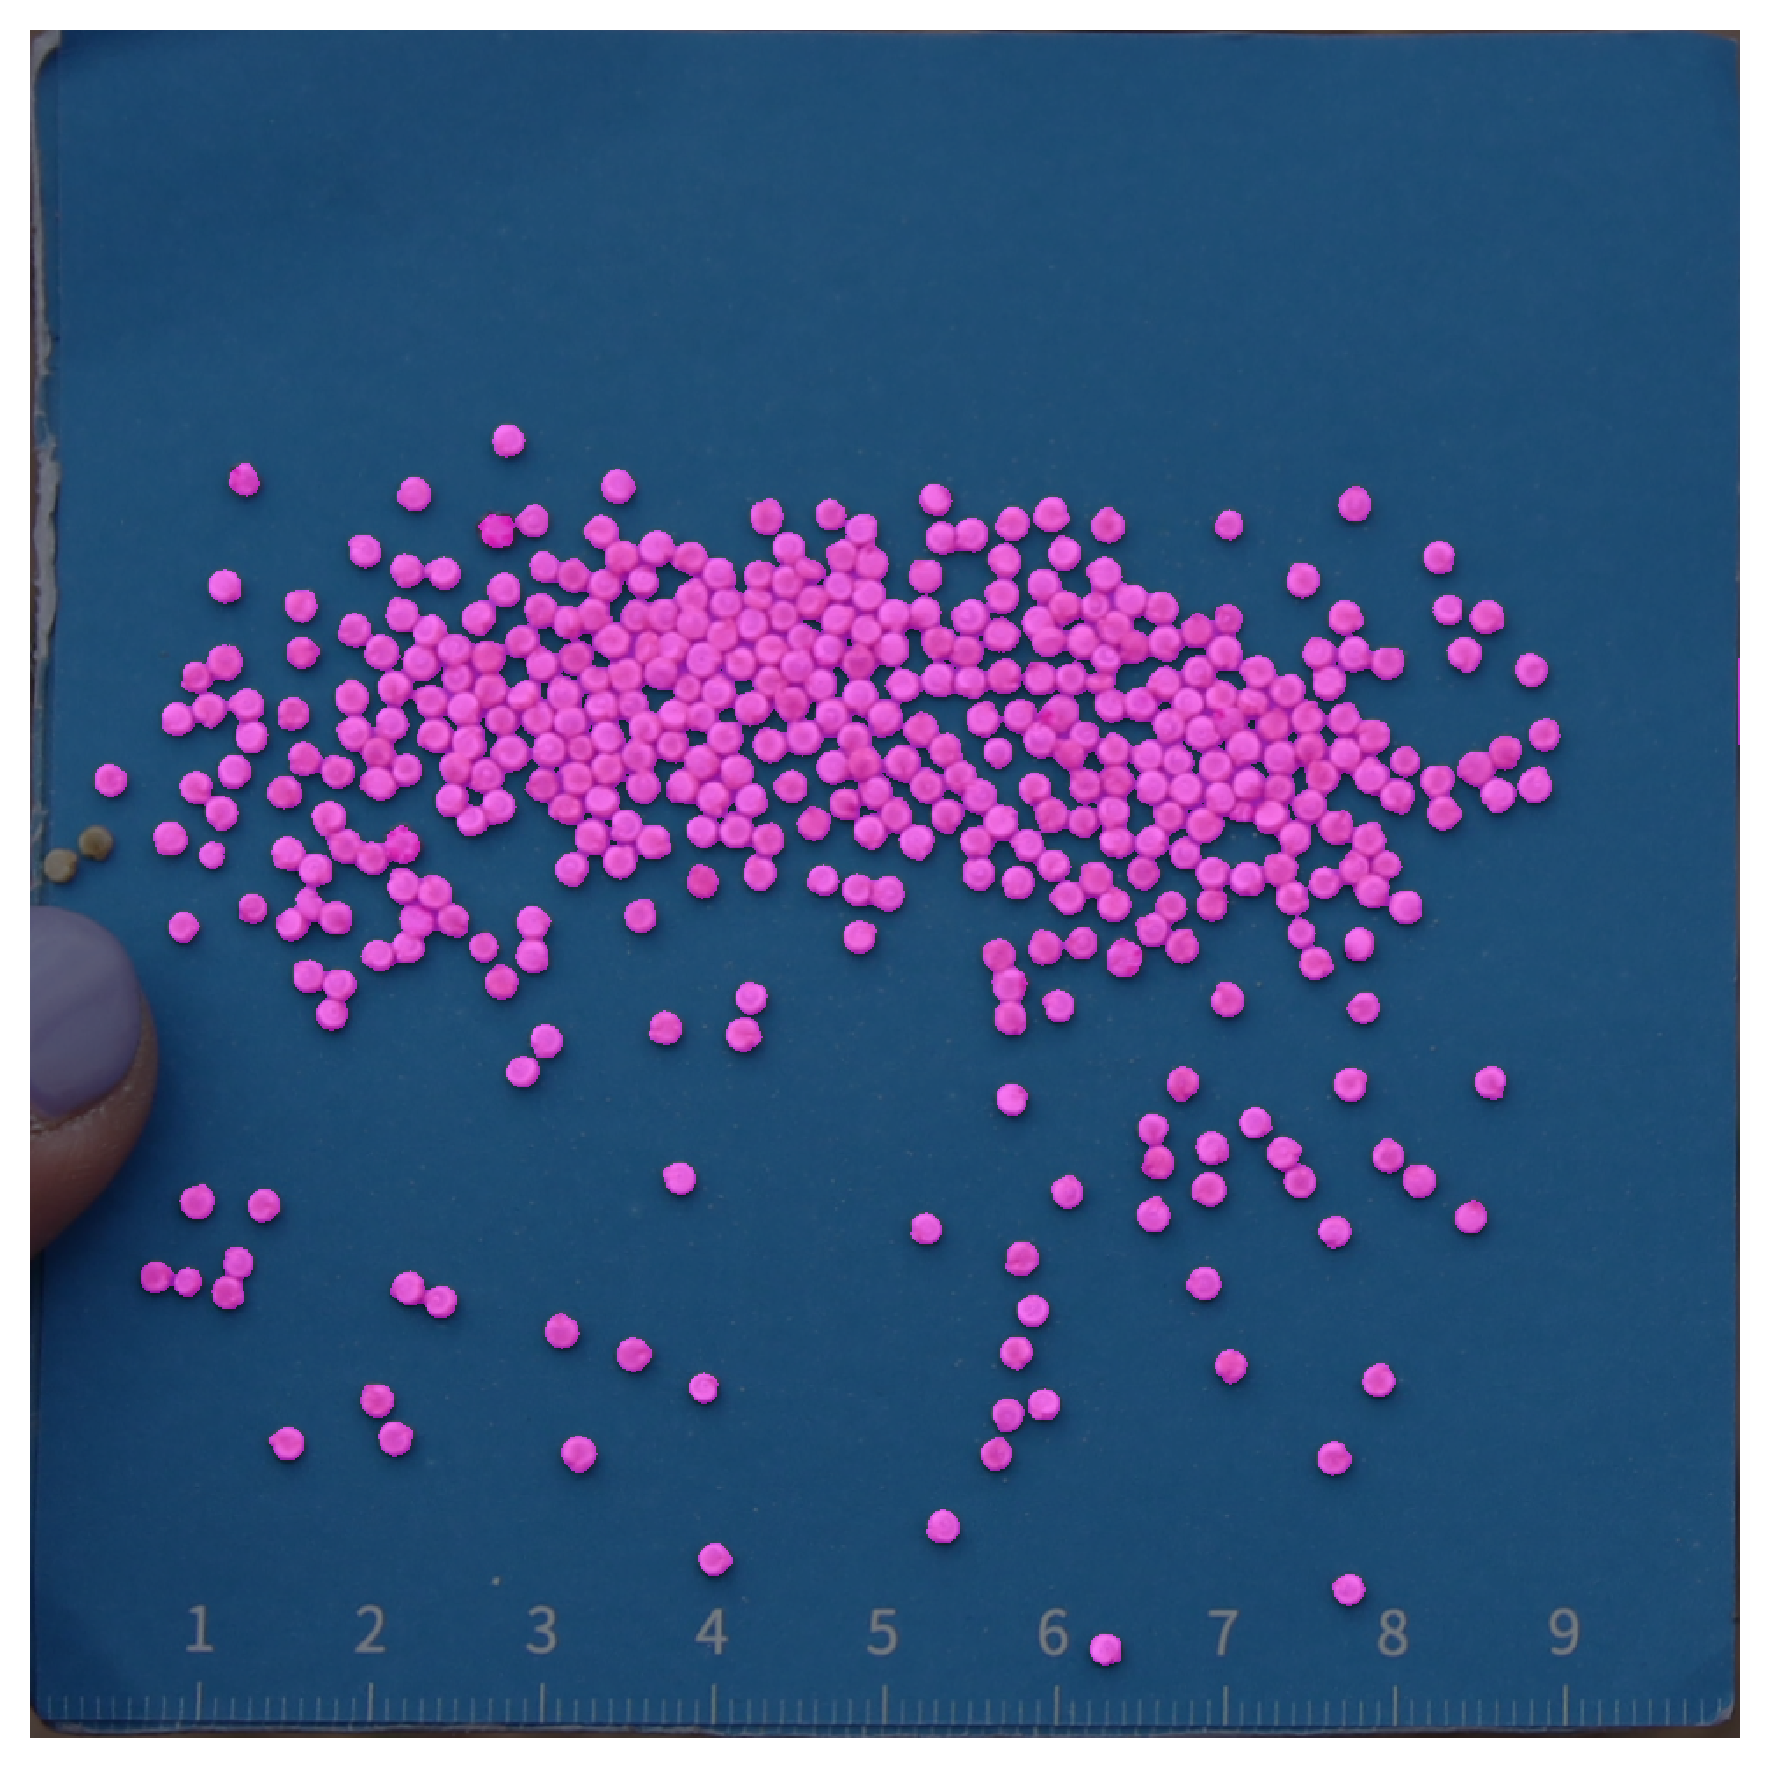

In [25]:
overlay = cv.addWeighted(show_labels, 0.5, img_bgr_cropped, 0.5, 0)
q.write_image(overlay, OUT / "overlay.png")
q.show_image(overlay)